In [1077]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm import tqdm

from lifelines.plotting import plot_lifetimes
from numpy.random import uniform, exponential

from sksurv.nonparametric import kaplan_meier_estimator
from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter
from lifelines import CoxPHFitter

from sksurv.preprocessing import OneHotEncoder

from sklearn.preprocessing import LabelEncoder

from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

pd.set_option('mode.chained_assignment', None)

In [894]:

# Use to restrict x-axis when displaying time-related data
DATE_RANGE = (pd.to_datetime('2016-09'), pd.to_datetime('2019-06-01'))

FIG_SIZE = (10, 6)
PALETTE = sns.color_palette()
plt.rcParams['figure.figsize'] = FIG_SIZE

def savefig(fig, name):
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )

### Load Dataset

In [592]:
df = pd.read_csv("../data/pre_issuedata.csv.gz", compression='gzip')
df

Unnamed: 0                                            message  \
0                 0  unexpected key "actions" for "job" section. ex...   
1                 1  unexpected key "actions" for "job" section. ex...   
2                 2        "steps" section is missing in job "Windows"   
3                 3         "steps" section is missing in job "Ubuntu"   
4                 4  workflow command "set-env" was deprecated. use...   
...             ...                                                ...   
1128854     1128854  label "ubuntu-22.04-8core" is unknown. availab...   
1128855     1128855  label "ubuntu-22.04-8core" is unknown. availab...   
1128856     1128856  workflow command "set-output" was deprecated. ...   
1128857     1128857  property "workspace" is not defined in object ...   
1128858     1128858  could not parse as YAML: yaml: line 24: did no...   

                                                  filepath  line  column  \
0        eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...     7       5   
1        eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...    33       5   
2        eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...    30       3   
3        eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...     4       3   
4        039caf0a23b2880cc6df745d11bda55cd77af51cac105a...    41      12   
...                                                    ...   ...     ...   
1128854  e8b89e16721022c609b3d3f9697754a0307204fae774ac...    23      11   
1128855  b2244ee2d58022030d84b50d99d135f62336918588c0c4...    24      11   
1128856  ae722a26cf35b3eed11746e51610381acf6e9534e9b010...    95      14   
1128857  e68a0e6591fd3e1c4b4b84b0755997ba8b0dbabad75208...    20      40   
1128858  eb88d4e8395934e1c7be96c553cfa5218c1fbf3d6d74c5...    24       0   

                        kind  \
0               syntax-check   
1               syntax-check   
2               syntax-check   
3               syntax-check   
4        deprecated-commands   
...                      ...   
1128854         runner-label   
1128855         runner-label   
1128856  deprecated-commands   
1128857           expression   
1128858          yaml-syntax   

                                                   snippet  end_column  \
0                                   actions:\n    ^~~~~~~~          12   
1                                   actions:\n    ^~~~~~~~          12   
2                                     Windows:\n  ^~~~~~~~          10   
3                                       Ubuntu:\n  ^~~~~~~           9   
4                                     run: |\n           ^          12   
...                                                    ...         ...   
1128854          - ubuntu-22.04-8core\n          ^~~~~~...          28   
1128855          - ubuntu-22.04-8core\n          ^~~~~~...          28   
1128856                             run: |\n             ^          14   
1128857                                             run: |          40   
1128858                                          msrv-all:           0   

                                          workflow_content  \
0        eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...   
1        eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...   
2        eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...   
3        eba966190e35f77ba001e0dc6de2dd8340bff6dadae2d4...   
4        039caf0a23b2880cc6df745d11bda55cd77af51cac105a...   
...                                                    ...   
1128854  e8b89e16721022c609b3d3f9697754a0307204fae774ac...   
1128855  b2244ee2d58022030d84b50d99d135f62336918588c0c4...   
1128856  ae722a26cf35b3eed11746e51610381acf6e9534e9b010...   
1128857  e68a0e6591fd3e1c4b4b84b0755997ba8b0dbabad75208...   
1128858  eb88d4e8395934e1c7be96c553cfa5218c1fbf3d6d74c5...   

                                     repository  ...                 date  \
0                             actions---toolkit  ...  2019-07-11 22:14:13   
1                             acti

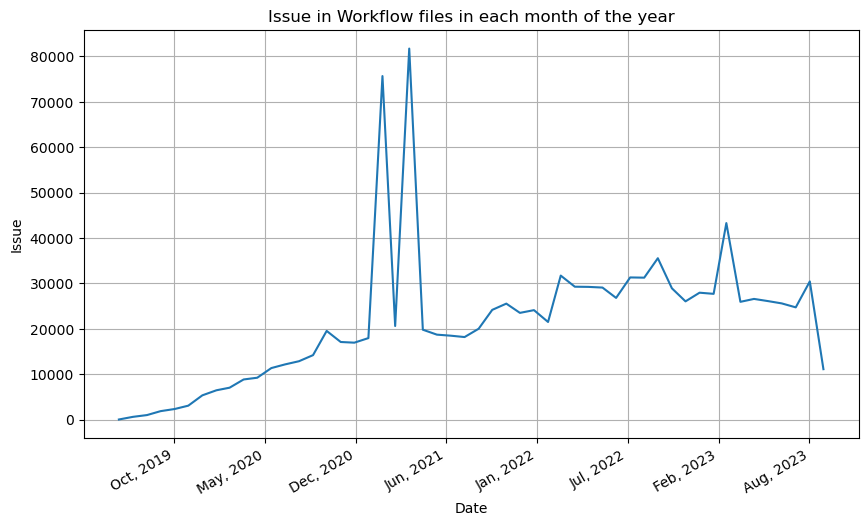

In [593]:
fig, ax = plt.subplots(figsize=(10, 6))

# gettinig the number of issues per month in the year
no_of_issue = (
    df
    .groupby(['commit_mon_year'], sort=True)
    .agg({'date': 'count'})
    .rename(columns={'date': 'no_of_issue'})
)

# converting the date to numeric
dates = mdates.date2num(no_of_issue.index)

ax.plot(dates, no_of_issue['no_of_issue'])
ax.set_title('Issue in Workflow files in each month of the year')
ax.set_xlabel('Date')
ax.set_ylabel('Issue')


# Add the grid
plt.grid(True)

# Format x-axis labels as dates
date_form = mdates.DateFormatter('%b, %Y')
ax.xaxis.set_major_formatter(date_form)

# ax.xaxis.set_major_locator(half_year_locator)

plt.gcf().autofmt_xdate()

plt.show()

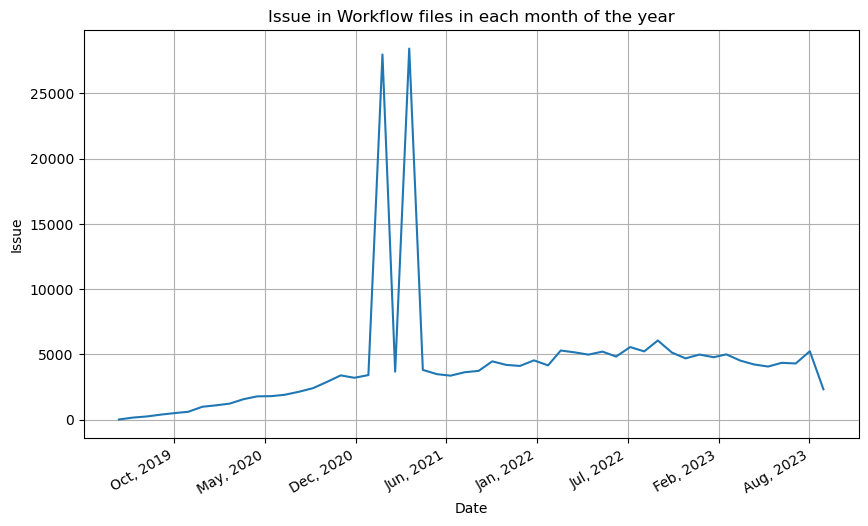

In [1101]:
fig, ax = plt.subplots(figsize=(10, 6))

# gettinig the number of issues per month in the year
no_of_issue = (
    df
    .drop_duplicates(['repository', 'workflow', 'commit_mon_year'], keep='last')
    .groupby(['commit_mon_year'], sort=True)
    .agg({'date': 'count'})
    .rename(columns={'date': 'no_of_issue'})
)

# converting the date to numeric
dates = mdates.date2num(no_of_issue.index)

ax.plot(dates, no_of_issue['no_of_issue'])
ax.set_title('Issue in Workflow files in each month of the year')
ax.set_xlabel('Date')
ax.set_ylabel('Issue')


# Add the grid
plt.grid(True)

# Format x-axis labels as dates
date_form = mdates.DateFormatter('%b, %Y')
ax.xaxis.set_major_formatter(date_form)

# ax.xaxis.set_major_locator(half_year_locator)

plt.gcf().autofmt_xdate()

plt.show()

In [594]:
df['kind'].value_counts()

deprecated-commands    368212
expression             292188
syntax-check           217987
runner-label           134139
yaml-syntax             37298
matrix                  23520
events                  18617
action                  15106
pyflakes                 8648
glob                     7117
job-needs                3252
id                       1347
shell-name                632
env-var                   401
permissions               235
workflow-call             160
Name: kind, dtype: int64

In [595]:
df['Rule'].value_counts()

Error Handling                            376888
Inefficient code                          271684
Configurations issue in the workflow      234224
Readability and Maintainability Issues    171645
Lack of Automated tests                    45316
Security vulnerabilities in code           12920
Compatibility issues                        9073
Code duplication                            7109
Name: Rule, dtype: int64

In [596]:
df['message'].nunique()

35325

In [597]:
df.columns

Index(['Unnamed: 0', 'message', 'filepath', 'line', 'column', 'kind',
       'snippet', 'end_column', 'workflow_content', 'repository', 'commit',
       'author_name', 'author_email', 'commiter_name', 'commiter_email',
       'date', 'workflow', 'change_type', 'lines_count', 'commit_year',
       'commit_mon_year', 'next_commit', 'status', 'time_taken', 'Rule'],
      dtype='object')

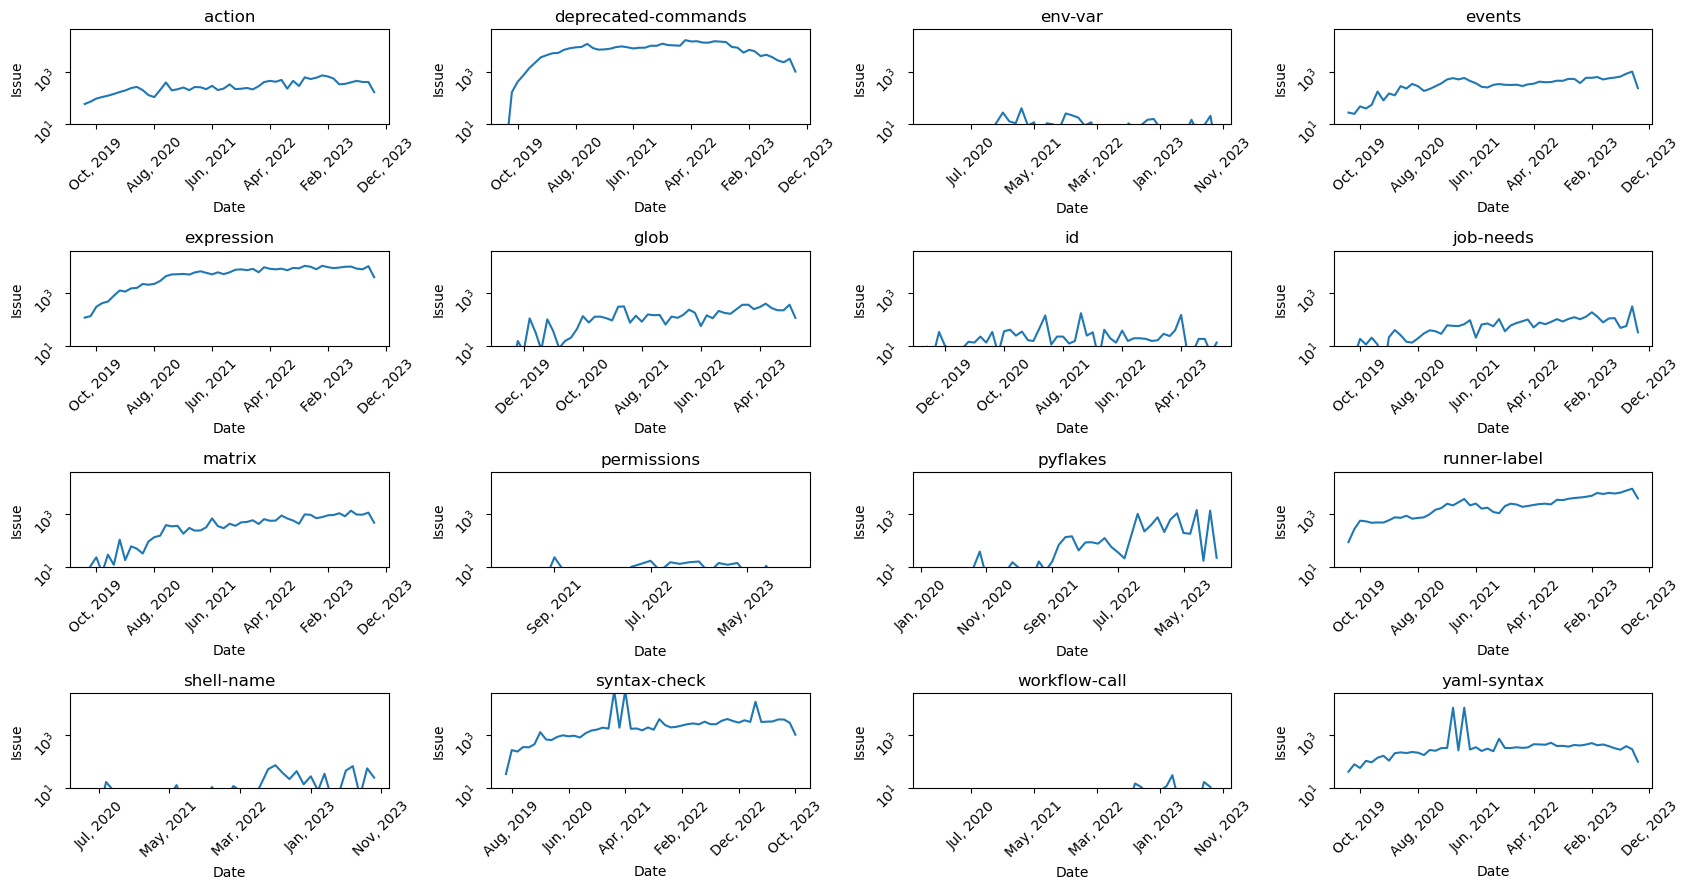

In [1016]:
no_issue_kind = (
    df
    .groupby(['kind','commit_mon_year'], as_index=False)
    .agg({'date': 'count'})
    .rename(columns={'date': 'no_of_issue'})
)

plt.rcParams.update({'figure.figsize':(17,9), 'figure.dpi':100})

kinds = no_issue_kind['kind'].unique()

def plotnew(ax, kind):
    data = no_issue_kind[no_issue_kind['kind'] == kind]
    ax.plot(mdates.date2num(data.commit_mon_year.values), data['no_of_issue'].values)
    ax.set_xlabel('Date')
    ax.set_ylabel('Issue')
   
    ax.set_title(kind)
    
        # Format x-axis labels as dates
    date_form = mdates.DateFormatter('%b, %Y')
    ax.xaxis.set_major_formatter(date_form)

    half_year_locator = mdates.MonthLocator(interval=10)
#     monthly_locator = mdates.MonthLocator()
    
    ax.xaxis.set_major_locator(half_year_locator)
#     ax.xaxis.set_minor_locator(monthly_locator)
    ax.set_ylim(10, 40000)
    ax.set_yscale('log')
    
    ax.tick_params(labelrotation=45)

   
    
    
fig, axes = plt.subplots(nrows=4, ncols=4)

for i, ax in enumerate(axes.flat):  # Start from 1 to 4 (ax1 to ax16)
    plotnew(ax, kinds[i])
    
# plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

In [811]:
# wf_issue_count = (
#     df
#     .groupby(['workflow','lines_count'], as_index=False)
#     .agg({'date': 'count'})
#     .rename(columns={'date': 'no_of_issue'})
# )

# plt.scatter(x=wf_issue_count['lines_count'], y=wf_issue_count['no_of_issue'])
# plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
# plt.title('Relationship of total number of issue versus total number of lines in each workflow file')
# plt.xlabel('Number of lines (logscale)')
# plt.ylabel('Number of issue (logscale)')

# plt.yscale("log")
# plt.xscale("log")


# plt.show()

In [603]:
df_group_rule = (df.groupby('Rule').agg({'Rule': 'count'})
    .rename(columns={'date': 'no_of_issue'}))
df_group_rule


Rule
Rule                                          
Code duplication                          7109
Compatibility issues                      9073
Configurations issue in the workflow    234224
Error Handling                          376888
Inefficient code                        271684
Lack of Automated tests                  45316
Readability and Maintainability Issues  171645
Security vulnerabilities in code         12920

In [604]:
df['Rule'].value_counts()

Error Handling                            376888
Inefficient code                          271684
Configurations issue in the workflow      234224
Readability and Maintainability Issues    171645
Lack of Automated tests                    45316
Security vulnerabilities in code           12920
Compatibility issues                        9073
Code duplication                            7109
Name: Rule, dtype: int64

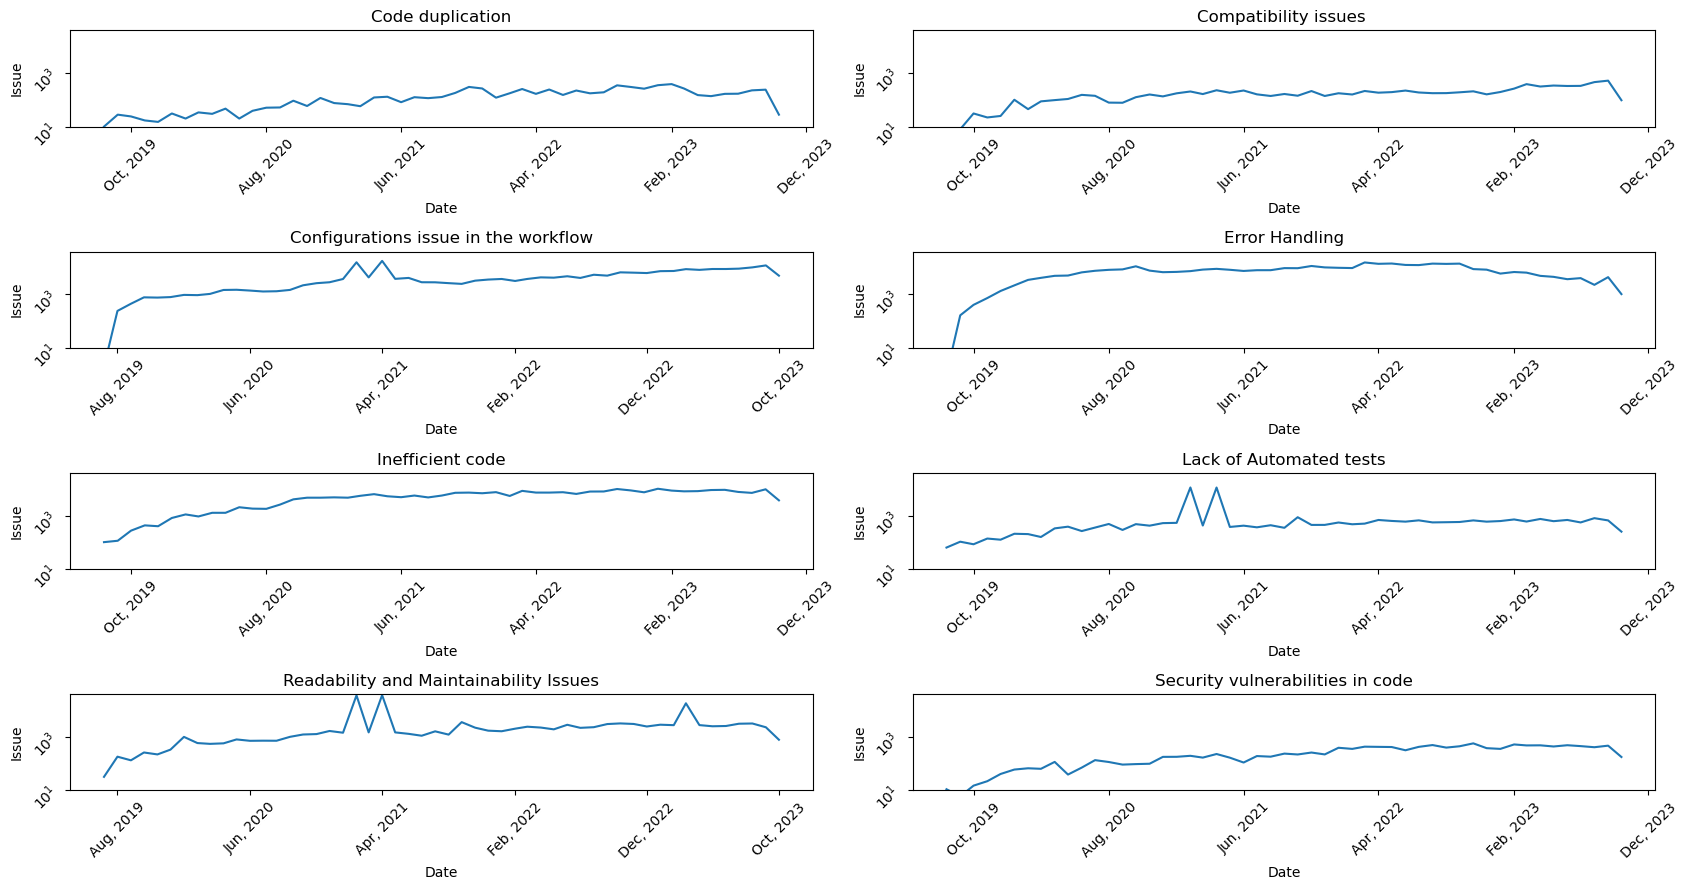

In [1017]:
no_issue_rule = (
    df
    .groupby(['Rule','commit_mon_year'], as_index=False)
    .agg({'date': 'count'})
    .rename(columns={'date': 'no_of_issue'})
)

plt.rcParams.update({'figure.figsize':(17,9), 'figure.dpi':100})

rule = no_issue_rule['Rule'].unique()

def plot_unique_rule(ax, rule):
    data = no_issue_rule[no_issue_rule['Rule'] == rule]
    ax.plot(mdates.date2num(data.commit_mon_year.values), data['no_of_issue'].values)
    ax.set_xlabel('Date')
    ax.set_ylabel('Issue')

    
    ax.set_yscale('log')
    
    ax.set_title(rule)
    
        # Format x-axis labels as dates
    date_form = mdates.DateFormatter('%b, %Y')
    ax.xaxis.set_major_formatter(date_form)

    half_year_locator = mdates.MonthLocator(interval=10)
#     monthly_locator = mdates.MonthLocator()
    
    ax.xaxis.set_major_locator(half_year_locator)
#     ax.xaxis.set_minor_locator(monthly_locator)
    ax.set_ylim(10, 40000)
    ax.set_yscale('log')
    ax.tick_params(labelrotation=45)

   
    
    
fig, axes = plt.subplots(nrows=4, ncols=2)

for i, ax in enumerate(axes.flat):  # Start from 1 to 4 (ax1 to ax16)
    plot_unique_rule(ax, rule[i])
    
# plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [623]:
no_issue_per_year = (
    df
    .groupby(['Rule', 'commit_year'], as_index=False)
    .agg({'commit': 'count'})
    .rename(columns={'commit': 'issue'})
)


The data is:[  94  594 1663 2626 2132]
The data is:[  91 1313 2149 2263 3257]
The data is:[ 3019 19024 67539 58169 86473]
The data is:[  2644  76912 104847 148103  44382]
The data is:[ 1327 27175 69098 92305 81779]
The data is:[  520  4125 27294  7086  6291]
The data is:[ 1163 10846 89478 29269 40889]
The data is:[  95 1133 2362 5052 4278]


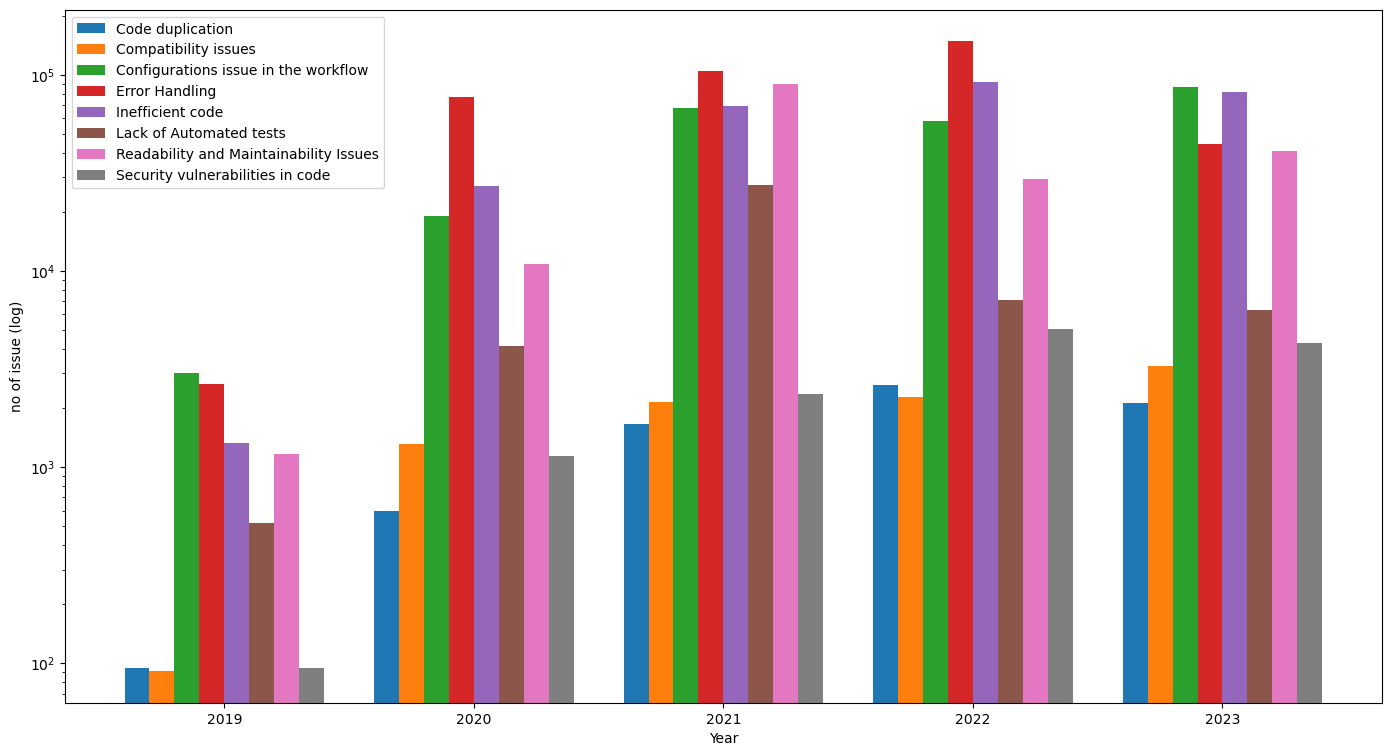

In [625]:
N = 5
ind = np.arange(N)  
width = 0.1
# plt.rcParams.update({'figure.figsize':(17,9), 'figure.dpi':100})  

bars = []
for i, rule in enumerate(no_issue_per_year['Rule'].unique()):
    data = no_issue_per_year[no_issue_per_year['Rule'] == rule]
    print("The data is:{}".format(data['issue'].values))
    bars.append(plt.bar(ind + width * i, data['issue'].values, width))
#     plt.bar_label(bars[i], padding = 15)
#     break
    
plt.xlabel("Year")
plt.ylabel('no of issue (log)')
plt.yscale('log')
# plt.title("Players Score")

plt.xticks(ind + width * (N - 1.5), no_issue_per_year['commit_year'].unique())

legend_labels = no_issue_per_commit['Rule'].unique()
plt.legend(bars, legend_labels)

plt.show()

In [611]:
no_issue_per_commit

Rule  commit_year  no_of_commit
0                         Code duplication         2019            94
1                         Code duplication         2020           594
2                         Code duplication         2021          1663
3                         Code duplication         2022          2626
4                         Code duplication         2023          2132
5                    Compatibility issues          2019            91
6                    Compatibility issues          2020          1313
7                    Compatibility issues          2021          2149
8                    Compatibility issues          2022          2263
9                    Compatibility issues          2023          3257
10    Configurations issue in the workflow         2019          3019
11    Configurations issue in the workflow         2020         19024
12    Configurations issue in the workflow         2021         67539
13    Configurations issue in the workflow         2022         58169
14    Configurations issue in the workflow         2023         86473
15                          Error Handling         2019          2644
16                          Error Handling         2020         76912
17                          Error Handling         2021        104847
18                          Error Handling         2022        148103
19                          Error Handling         2023         44382
20                        Inefficient code         2019          1327
21                        Inefficient code         2020         27175
22                        Inefficient code         2021         69098
23                        Inefficient code         2022         92305
24                        Inefficient code         2023         81779
25                 Lack of Automated tests         2019           520
26                 Lack of Automated tests         2020          4125
27                 Lack of Automated tests         2021         27294
28                 Lack of Automated tests         2022          7086
29                 Lack of Automated tests         2023          6291
30  Readability and Maintainability Issues         2019          1163
31  Readability and Maintainability Issues         2020         10846
32  Readability and Maintainability Issues         2021         89478
33  Readability and Maintainability Issues         2022         29269
34  Readability and Maintainability Issues         2023         40889
35        Security vulnerabilities in code         2019            95
36        Security vulnerabilities in code         2020          1133
37        Security vulnerabilities in code         2021          2362
38        Security vulnerabilities in code         2022          5052
39        Security vulnerabilities in code         2023          4278

## Dataset Feature Corelation

Converting the value of the features into numeric values

In [990]:
objects_cols = df.select_dtypes(include = ['object']).columns
df_cor = df.copy()
df_cor = df_cor.drop('Unnamed: 0', axis = 1)
for col in objects_cols:
    df_cor[col] = np.uint8(LabelEncoder().fit_transform(df_cor[col]))
# df_cor = df[['message','line','column', 'kind', 'end_column', 'repository', 'commit', 'workflow', 'lines_count', 'commit_year','commit_mon_year']]
# 

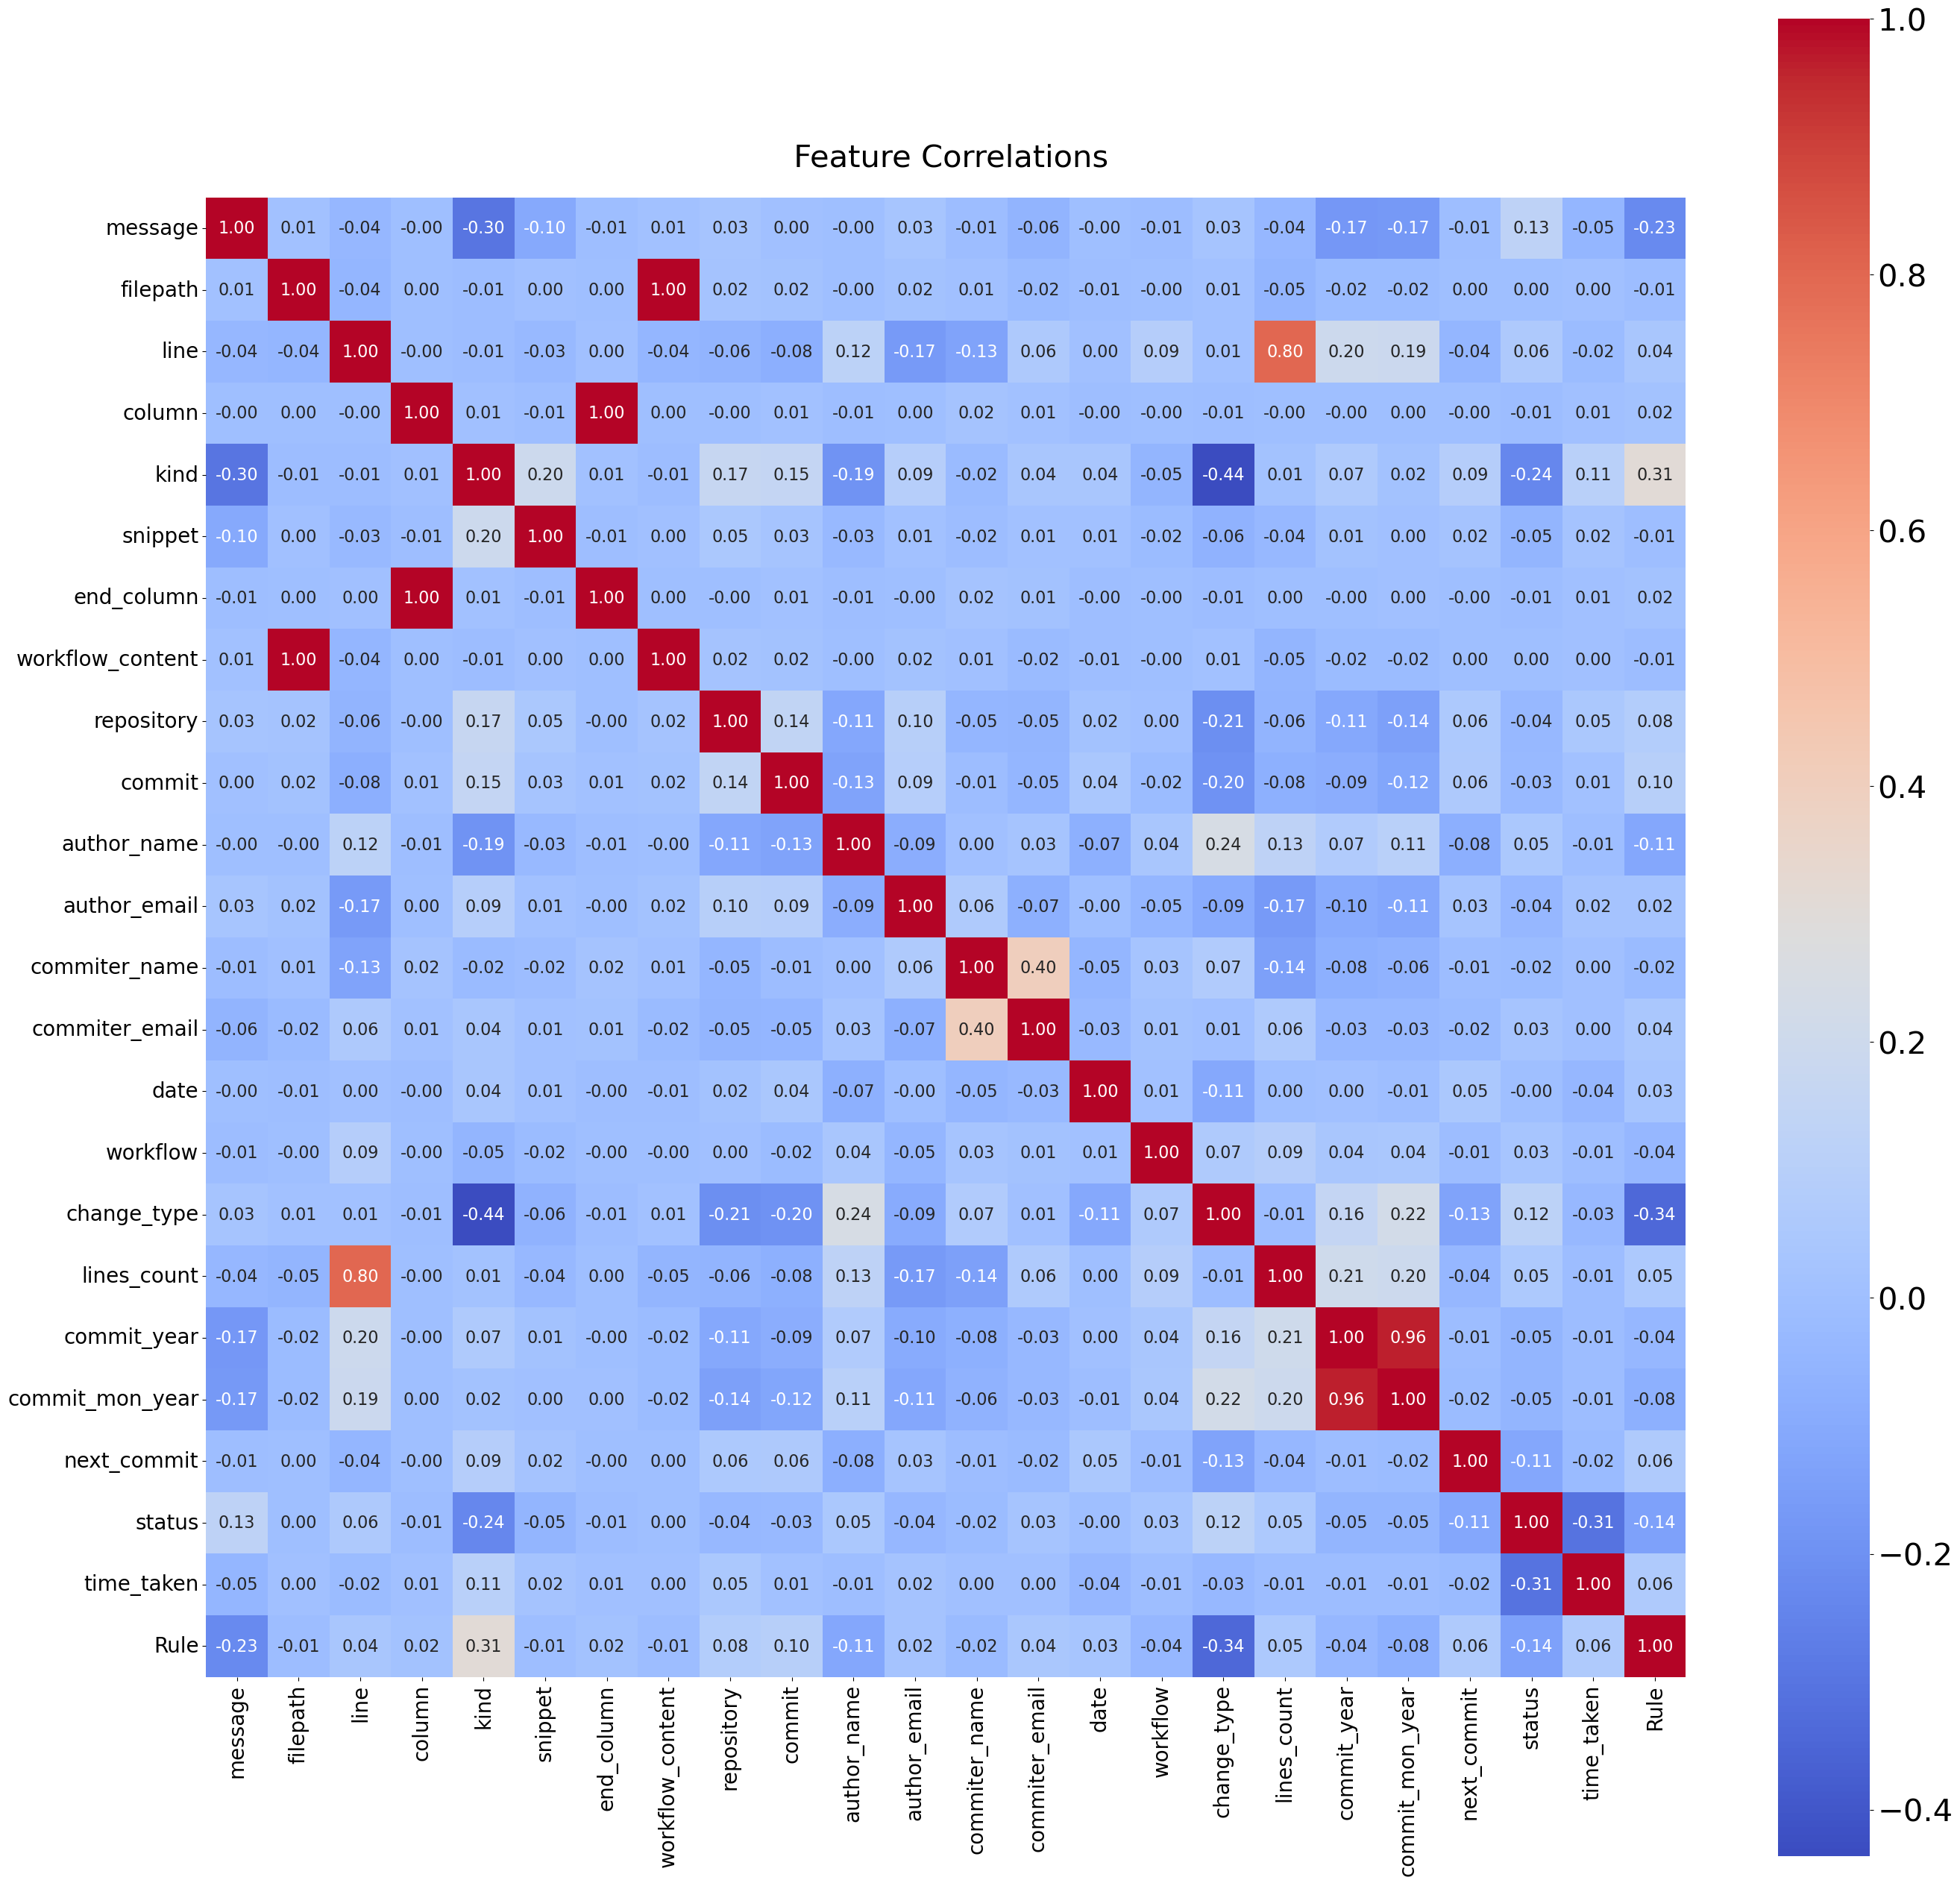

In [992]:
fig = plt.figure(figsize=(32, 32), dpi=100)

ax = sns.heatmap(df_cor.corr(), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 16},  fmt='.2f')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

plt.tick_params(axis='x', labelsize=20, rotation=90)
plt.tick_params(axis='y', labelsize=20, rotation=0)
plt.title(' Feature Correlations', size=30, pad=30)

plt.show()

In [1109]:
df_cor.corr().style.background_gradient(axis=None, vmin=-1, vmax=1, ).format("{:0.2f}")

## Average time taken for each Rule to reslove the issue

Text(0.5, 1.0, 'Average Time Taken to reolve issues(error) based on the rules')

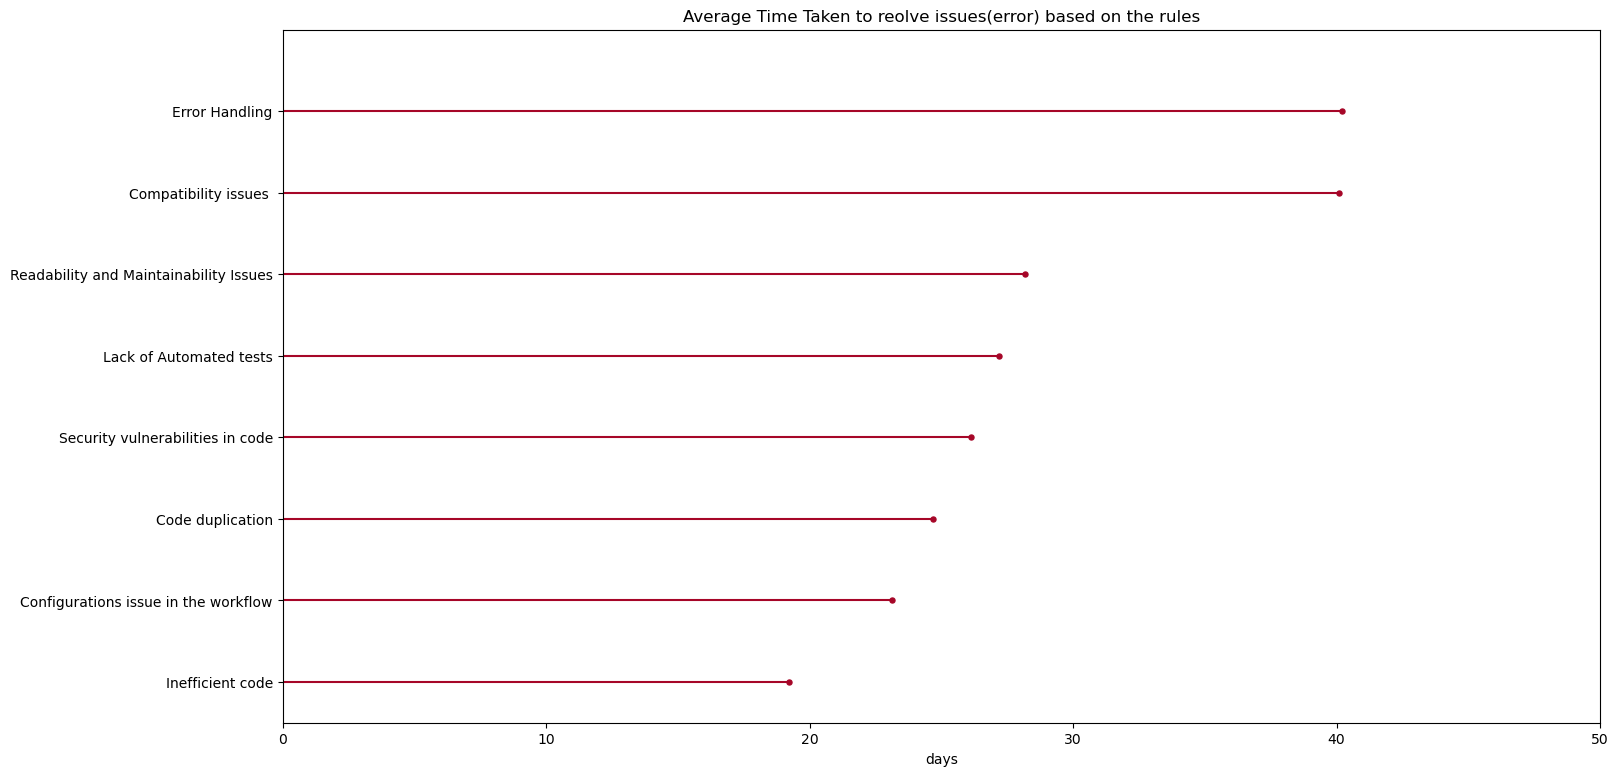

In [1018]:
df['time_taken_type_change'] = pd.to_timedelta(df['time_taken'], errors='coerce')

mean_time_taken_rules = df.groupby(df.Rule)['time_taken_type_change'].mean()
components = mean_time_taken_rules.dt.components
components['days_and_hours'] = components[components.columns[0:2]].apply(
    lambda x: '.'.join(x.dropna().astype(str)),
    axis=1
)
df.drop(['time_taken_type_change'], axis=1, inplace = True)

ax = plot_lifetimes(components['days_and_hours'].astype(float))

ax.set_xlim(0, 50)
# ax.vlines(10, 0, 30, lw=2, linestyles='--')
ax.set_xlabel("days")
ax.set_title("Average Time Taken to reolve issues(error) based on the rules")

# Survival Models

Survival estimation can be classified into three main groups: non-parametric, semi parametric, and parametric approaches. Parametric methods depends on the assumptions that survival time correspond to the specific probability distribution. This group consisits of methods such as exponential, Weibull and lognormal distributions. In the non-parametric methods there are no dependencies dependent on the underlying distributions. Mostly, the non-parametric approach is used to describe survival probabilities as a function of time and give an average views of the individuals population. Most popular univariate method is the Kaplan-Meier estimator. Cox regression model comes under semi-parametric methods as it depends on parametric as well as non-parametric. 

## Kaplan Meier Curve

The Kaplan Meier curve is used to graphically represent the survival rate or survival function

In [802]:
def plot_kpl_curve(rules, dataframe):
    for rule in rules:
        df_rule = dataframe[dataframe['Rule'] == rule]  
        df_rule['mapping_time_taken'] = df_rule['time_taken'].apply(lambda x : False if x == "unresolved error" else True)
        df_rule['time_taken_delta'] = df_rule['time_taken'].apply(lambda x : pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "unresolved error" else 0)


        kmf = KaplanMeierFitter()
        kmf.fit(durations=df_rule["time_taken_delta"], event_observed=df_rule["mapping_time_taken"])

        time = kmf.survival_function_.index.values
        survival_prob = kmf.survival_function_.values[:, 0]
        conf_int = kmf.confidence_interval_.values

        plt.step(time, survival_prob, where="post", label=rule)
        plt.fill_between(time, conf_int[:, 0], conf_int[:, 1], alpha=0.25, step="post")
        
        
    plt.ylim(0, 1)
    plt.legend(loc='upper right')
    plt.title("Kaplan Meier Curve for Rules")
    plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    
    
    
    
def plot_kpl_curve_subplot(rules, dataframe, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    for i, rule in enumerate(rules):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        
        df_rule = dataframe[dataframe['Rule'] == rule]
        df_rule['mapping_time_taken'] = df_rule['time_taken'].apply(lambda x: False if x == "unresolved error" else True)
        df_rule['time_taken_delta'] = df_rule['time_taken'].apply(lambda x: pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "unresolved error" else 0)

        
        
        kmf = KaplanMeierFitter()
        kmf.fit(durations=df_rule["time_taken_delta"], event_observed=df_rule["mapping_time_taken"])

        time = kmf.survival_function_.index.values
        survival_prob = kmf.survival_function_.values[:, 0]
        conf_int = kmf.confidence_interval_.values
        
        
        ax.step(time, survival_prob, where="post", label=rule)
        ax.fill_between(time, conf_int[:, 0], conf_int[:, 1], alpha=0.25, step="post")
        ax.set_ylim(0, 1)
        ax.legend(loc='upper right')
#         ax.set_title("Kaplan Meier Curve for Rule: " + rule)
        ax.set_ylabel(r"est. probability of survival $\hat{S}(t)$")
        ax.set_xlabel("time $t$")

    plt.tight_layout()
    plt.show()

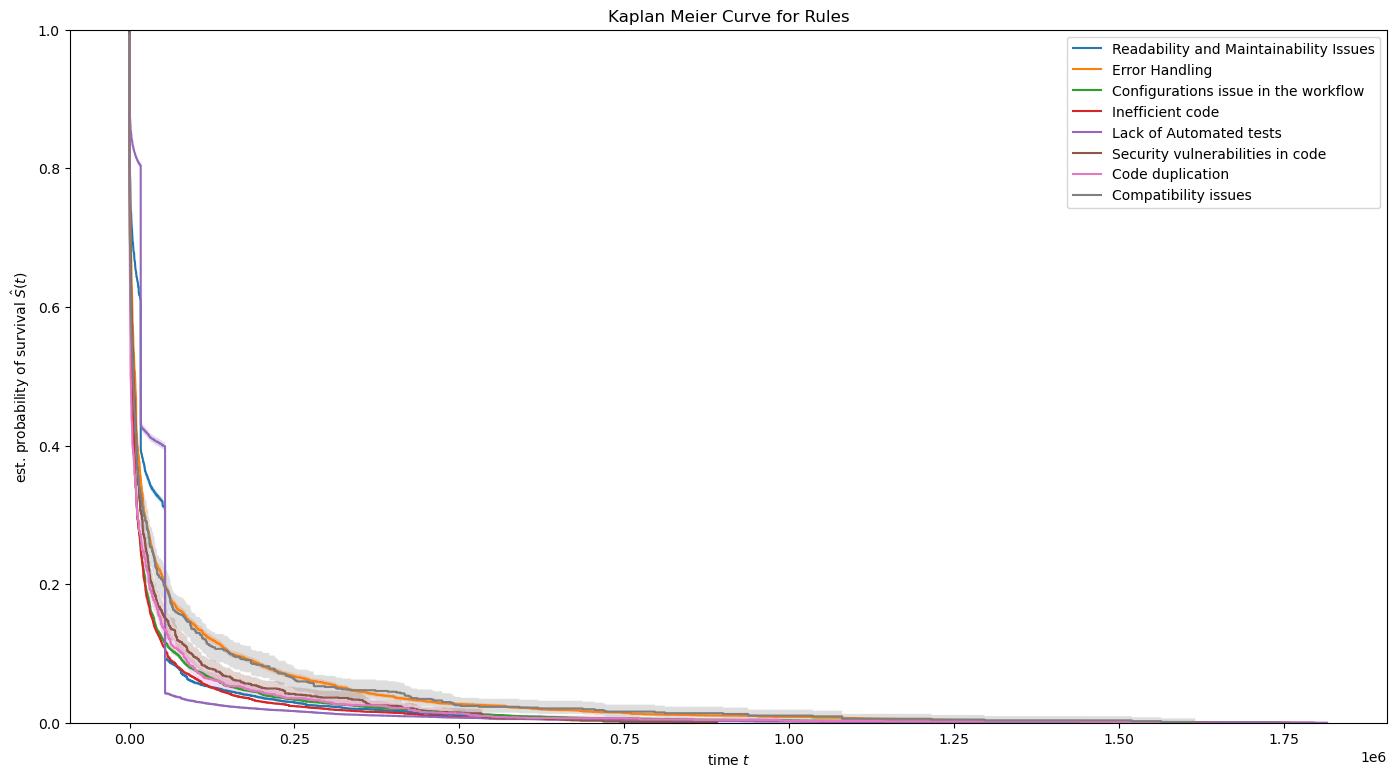

In [1020]:
plot_kpl_curve(df['Rule'].unique() ,df)

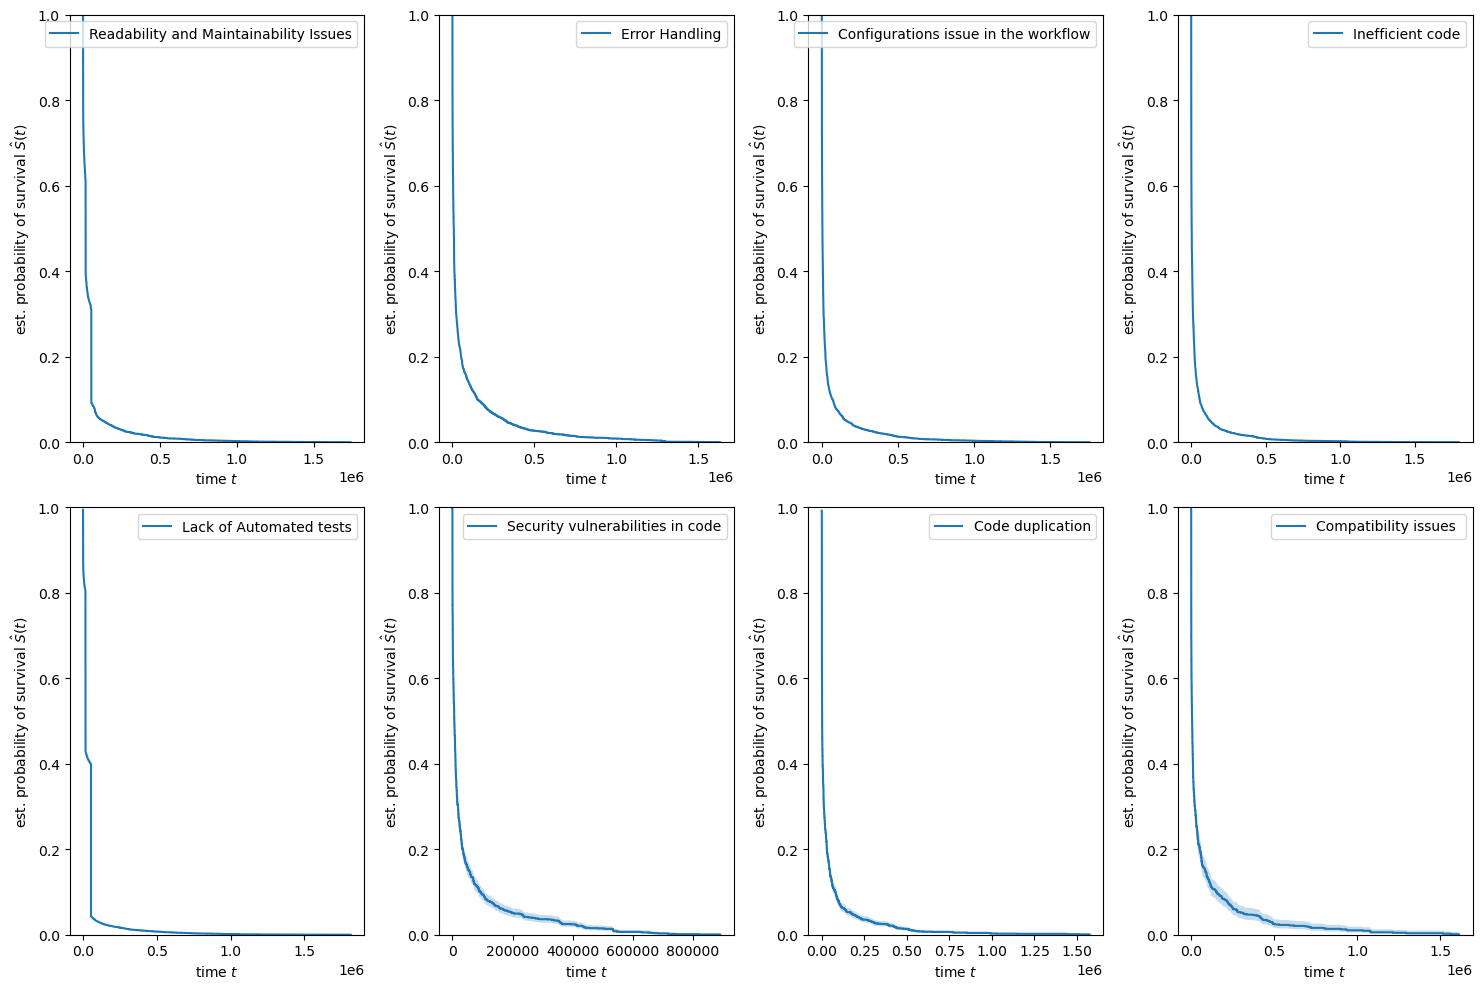

In [1021]:
plot_kpl_curve_subplot(df['Rule'].unique(), df, 2, 4)

In [804]:
# df_code_duplication = df[df['Rule'] == "Code duplication"]  
# df_code_duplication['mapping_time_taken'] = df_code_duplication['time_taken'].apply(lambda x : False if x == "unresolved error" else True)
# df_code_duplication['time_taken_delta'] = df_code_duplication['time_taken'].apply(lambda x : pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "unresolved error" else 0)


# time, survival_prob, conf_int = kaplan_meier_estimator(
#     df_code_duplication["mapping_time_taken"], df_code_duplication["time_taken_delta"], conf_type="log-log"
# )
# plt.step(time, survival_prob, where="post")
# plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
# plt.ylim(0, 1)
# plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
# plt.xlabel("time $t$")


In [806]:
# df_error_handling = df[df['Rule'] == "Error Handling"]  
# df_error_handling['mapping_time_taken'] = df_error_handling['time_taken'].apply(lambda x : False if x == "unresolved error" else True)
# df_error_handling['time_taken_delta'] = df_error_handling['time_taken'].apply(lambda x : pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "unresolved error" else 0)


# time, survival_prob, conf_int = kaplan_meier_estimator(
#     df_error_handling["mapping_time_taken"], df_error_handling["time_taken_delta"], conf_type="log-log"
# )
# plt.step(time, survival_prob, where="post")
# plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
# plt.ylim(0, 1)
# plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
# plt.xlabel("time $t$")

In [807]:
# df_inefficient_code = df[df['Rule'] == "Inefficient code"]  
# df_inefficient_code['mapping_time_taken'] = df_inefficient_code['time_taken'].apply(lambda x : False if x == "unresolved error" else True)
# df_inefficient_code['time_taken_delta'] = df_inefficient_code['time_taken'].apply(lambda x : pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "unresolved error" else 0)


# time, survival_prob, conf_int = kaplan_meier_estimator(
#     df_inefficient_code["mapping_time_taken"], df_inefficient_code["time_taken_delta"], conf_type="log-log"
# )
# plt.step(time, survival_prob, where="post")
# plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
# plt.ylim(0, 1)
# plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
# plt.xlabel("time $t$")

In [808]:
# df_configuration_issue = df[df['Rule'] == "Configurations issue in the workflow"]  
# df_configuration_issue['mapping_time_taken'] = df_configuration_issue['time_taken'].apply(lambda x : False if x == "unresolved error" else True)
# df_configuration_issue['time_taken_delta'] = df_configuration_issue['time_taken'].apply(lambda x : pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "unresolved error" else 0)


# time, survival_prob, conf_int = kaplan_meier_estimator(
#     df_configuration_issue["mapping_time_taken"], df_configuration_issue["time_taken_delta"], conf_type="log-log"
# )
# plt.step(time, survival_prob, where="post")
# plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
# plt.ylim(0, 1)
# plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
# plt.xlabel("time $t$")

In [809]:
# df_readibility_issue= df[df['Rule'] == "Readability and Maintainability Issues"]  
# df_readibility_issue['mapping_time_taken'] = df_readibility_issue['time_taken'].apply(lambda x : False if x == "unresolved error" else True)
# df_readibility_issue['time_taken_delta'] = df_readibility_issue['time_taken'].apply(lambda x : pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "unresolved error" else 0)


# time, survival_prob, conf_int = kaplan_meier_estimator(
#     df_readibility_issue["mapping_time_taken"], df_readibility_issue["time_taken_delta"], conf_type="log-log"
# )
# plt.step(time, survival_prob, where="post")
# plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
# plt.ylim(0, 1)
# plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
# plt.xlabel("time $t$")

# Estimating cumulative hazards using parametric models

## Weibull model

In [1094]:
def plot_weibull_subplot(rules, dataframe, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    for i, rule in enumerate(rules):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        
        df_rule = dataframe[dataframe['Rule'] == rule]
        df_rule['mapping_time_taken'] = df_rule['time_taken'].apply(lambda x: False if x == "unresolved error" else True)
        df_rule['time_taken_delta'] = df_rule['time_taken'].apply(lambda x: pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "unresolved error" else 0)

        df_rule["time_taken_delta"] = df_rule["time_taken_delta"].apply(lambda x: max(x, 1e-5))
        
        print("The rule is:{}".format(rule))
        wf= WeibullFitter()
        wf.fit(durations=df_rule["time_taken_delta"], event_observed=df_rule["mapping_time_taken"])

        wf.print_summary()
        ax = wf.plot_cumulative_hazard(ax = ax)
#         ax.legend(rule)
        

#     ax.set_title("Cumulative hazard of Weibull model; estimated parameters")
    plt.tight_layout()
    plt.show()
    
def plot_weibull(rules, dataframe):
    fig, ax = plt.subplots()
    for rule in rules:
        df_rule = dataframe[dataframe['Rule'] == rule]  
        df_rule['mapping_time_taken'] = df_rule['time_taken'].apply(lambda x : False if x == "unresolved error" else True)
        df_rule['time_taken_delta'] = df_rule['time_taken'].apply(lambda x : pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "unresolved error" else 0)


        df_rule["time_taken_delta"] = df_rule["time_taken_delta"].apply(lambda x: max(x, 1e-5))
        
        print("The rule is:{}".format(rule))
        wf= WeibullFitter()
        wf.fit(durations=df_rule["time_taken_delta"], event_observed=df_rule["mapping_time_taken"])

        wf.print_summary()
        ax = wf.plot_cumulative_hazard()
        
        
    ax.legend(rules,loc='upper right')
    plt.xscale('log')
#     plt.yticks(np.arange(0, 12, 4.0))
    ax.set_title("Cumulative hazard of Weibull model; estimated parameters")
#     plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
    plt.xlabel("timeline $t$")

The rule is:Readability and Maintainability Issues


<lifelines.WeibullFitter:"Weibull_estimate", fitted with 171645 total observations, 137240 right-censored observations>
   number of observations = 171645
number of events observed = 34405
           log-likelihood = -371526.60
               hypothesis = lambda_ != 1, rho_ != 1

---
            coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 18986.90     250.77         18495.40         19478.40
rho_        0.42       0.00             0.42             0.43

          cmp to       z      p   -log2(p)
lambda_     1.00   75.71 <0.005        inf
rho_        1.00 -303.04 <0.005        inf
---
AIC = 743057.20

The rule is:Error Handling


<lifelines.WeibullFitter:"Weibull_estimate", fitted with 376888 total observations, 363289 right-censored observations>
   number of observations = 376888
number of events observed = 13599
           log-likelihood = -143096.29
               hypothesis = lambda_ != 1, rho_ != 1

---
            coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 16225.31     381.97         15476.67         16973.96
rho_        0.37       0.00             0.37             0.38

          cmp to       z      p   -log2(p)
lambda_     1.00   42.48 <0.005        inf
rho_        1.00 -295.79 <0.005        inf
---
AIC = 286196.59

The rule is:Configurations issue in the workflow


<lifelines.WeibullFitter:"Weibull_estimate", fitted with 234224 total observations, 203485 right-censored observations>
   number of observations = 234224
number of events observed = 30739
           log-likelihood = -302726.52
               hypothesis = lambda_ != 1, rho_ != 1

---
           coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 7793.79     128.10          7542.72          8044.86
rho_       0.36       0.00             0.36             0.36

          cmp to       z      p   -log2(p)
lambda_     1.00   60.83 <0.005        inf
rho_        1.00 -425.73 <0.005        inf
---
AIC = 605457.05

The rule is:Inefficient code


<lifelines.WeibullFitter:"Weibull_estimate", fitted with 271684 total observations, 237872 right-censored observations>
   number of observations = 271684
number of events observed = 33812
           log-likelihood = -323900.88
               hypothesis = lambda_ != 1, rho_ != 1

---
           coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 6356.23     101.94          6156.43          6556.03
rho_       0.35       0.00             0.35             0.35

          cmp to       z      p   -log2(p)
lambda_     1.00   62.34 <0.005        inf
rho_        1.00 -470.15 <0.005        inf
---
AIC = 647805.75

The rule is:Lack of Automated tests


<lifelines.WeibullFitter:"Weibull_estimate", fitted with 45316 total observations, 16235 right-censored observations>
   number of observations = 45316
number of events observed = 29081
           log-likelihood = -328679.13
               hypothesis = lambda_ != 1, rho_ != 1

---
            coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 28638.20     291.65         28066.57         29209.83
rho_        0.59       0.00             0.59             0.60

          cmp to       z      p   -log2(p)
lambda_     1.00   98.19 <0.005        inf
rho_        1.00 -138.96 <0.005        inf
---
AIC = 657362.26

The rule is:Security vulnerabilities in code


<lifelines.WeibullFitter:"Weibull_estimate", fitted with 12920 total observations, 11217 right-censored observations>
   number of observations = 12920
number of events observed = 1703
           log-likelihood = -17542.67
               hypothesis = lambda_ != 1, rho_ != 1

---
            coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 11421.97     751.51          9949.03         12894.91
rho_        0.38       0.01             0.37             0.40

          cmp to      z      p   -log2(p)
lambda_     1.00  15.20 <0.005     170.86
rho_        1.00 -87.46 <0.005        inf
---
AIC = 35089.34

The rule is:Code duplication


<lifelines.WeibullFitter:"Weibull_estimate", fitted with 7109 total observations, 4599 right-censored observations>
   number of observations = 7109
number of events observed = 2510
           log-likelihood = -23616.09
               hypothesis = lambda_ != 1, rho_ != 1

---
           coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 5540.71     371.90          4811.79          6269.62
rho_       0.31       0.00             0.30             0.32

          cmp to       z      p   -log2(p)
lambda_     1.00   14.90 <0.005     164.28
rho_        1.00 -146.96 <0.005        inf
---
AIC = 47236.17

The rule is:Compatibility issues 


<lifelines.WeibullFitter:"Weibull_estimate", fitted with 9073 total observations, 8164 right-censored observations>
   number of observations = 9073
number of events observed = 909
           log-likelihood = -9007.57
               hypothesis = lambda_ != 1, rho_ != 1

---
            coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 10651.80    1142.88          8411.80         12891.81
rho_        0.32       0.01             0.30             0.33

          cmp to      z      p   -log2(p)
lambda_     1.00   9.32 <0.005      66.21
rho_        1.00 -95.82 <0.005        inf
---
AIC = 18019.14

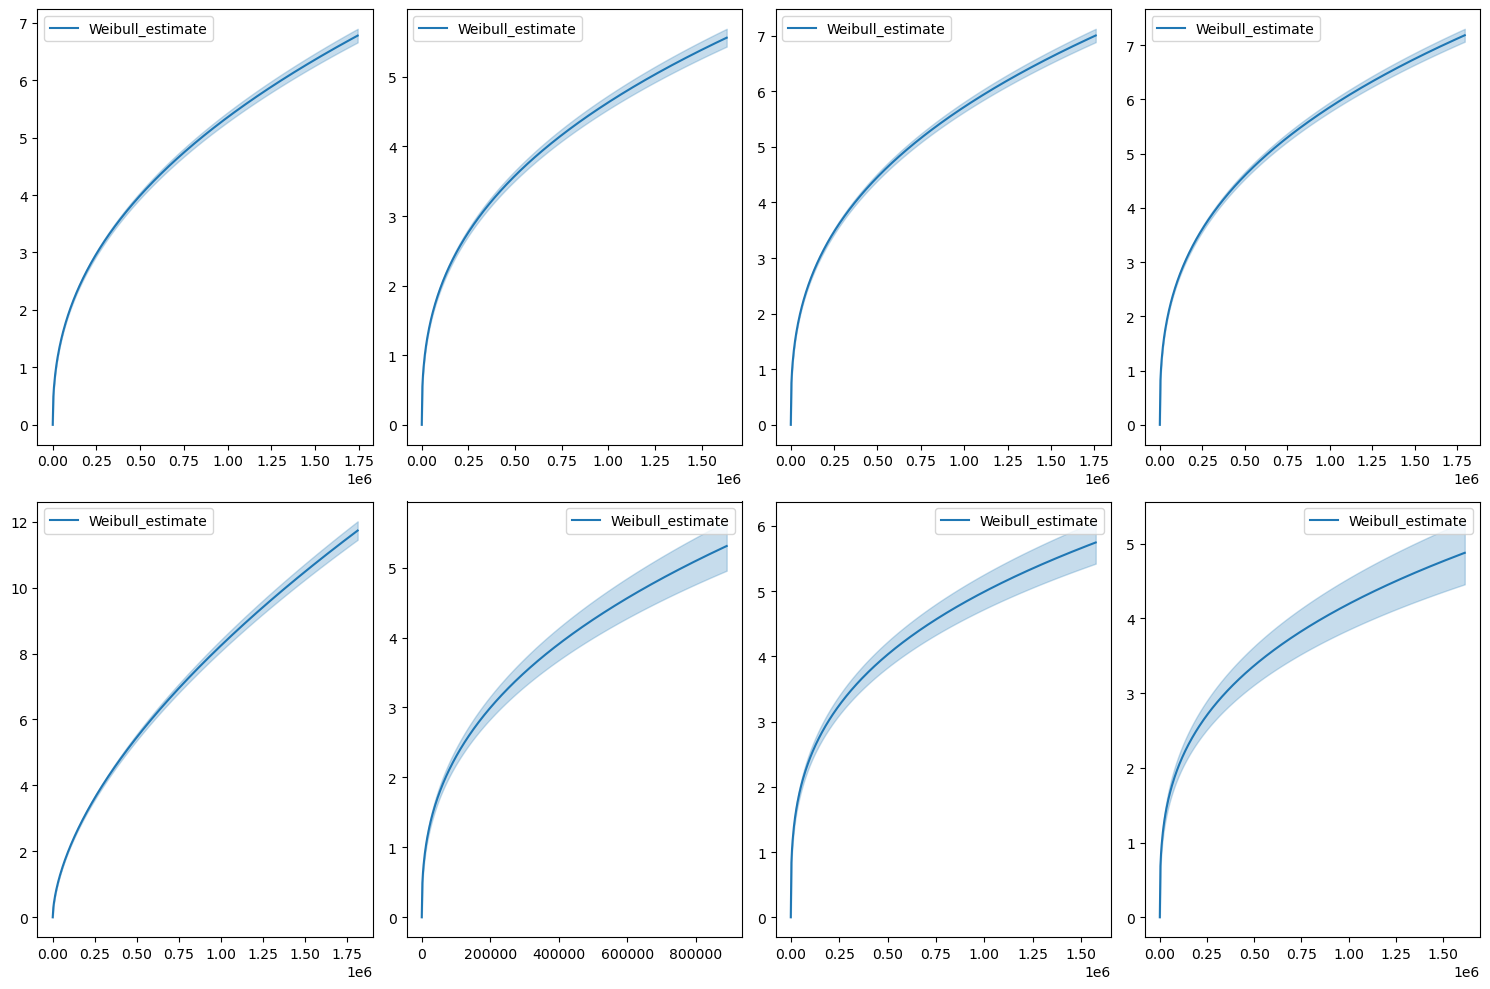

In [1095]:
plot_weibull_subplot(df['Rule'].unique(), df, 2, 4)

The rule is:Readability and Maintainability Issues


<lifelines.WeibullFitter:"Weibull_estimate", fitted with 171645 total observations, 137240 right-censored observations>
   number of observations = 171645
number of events observed = 34405
           log-likelihood = -371526.60
               hypothesis = lambda_ != 1, rho_ != 1

---
            coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 18986.90     250.77         18495.40         19478.40
rho_        0.42       0.00             0.42             0.43

          cmp to       z      p   -log2(p)
lambda_     1.00   75.71 <0.005        inf
rho_        1.00 -303.04 <0.005        inf
---
AIC = 743057.20

The rule is:Error Handling


<lifelines.WeibullFitter:"Weibull_estimate", fitted with 376888 total observations, 363289 right-censored observations>
   number of observations = 376888
number of events observed = 13599
           log-likelihood = -143096.29
               hypothesis = lambda_ != 1, rho_ != 1

---
            coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 16225.31     381.97         15476.67         16973.96
rho_        0.37       0.00             0.37             0.38

          cmp to       z      p   -log2(p)
lambda_     1.00   42.48 <0.005        inf
rho_        1.00 -295.79 <0.005        inf
---
AIC = 286196.59

The rule is:Configurations issue in the workflow


<lifelines.WeibullFitter:"Weibull_estimate", fitted with 234224 total observations, 203485 right-censored observations>
   number of observations = 234224
number of events observed = 30739
           log-likelihood = -302726.52
               hypothesis = lambda_ != 1, rho_ != 1

---
           coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 7793.79     128.10          7542.72          8044.86
rho_       0.36       0.00             0.36             0.36

          cmp to       z      p   -log2(p)
lambda_     1.00   60.83 <0.005        inf
rho_        1.00 -425.73 <0.005        inf
---
AIC = 605457.05

The rule is:Inefficient code


<lifelines.WeibullFitter:"Weibull_estimate", fitted with 271684 total observations, 237872 right-censored observations>
   number of observations = 271684
number of events observed = 33812
           log-likelihood = -323900.88
               hypothesis = lambda_ != 1, rho_ != 1

---
           coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 6356.23     101.94          6156.43          6556.03
rho_       0.35       0.00             0.35             0.35

          cmp to       z      p   -log2(p)
lambda_     1.00   62.34 <0.005        inf
rho_        1.00 -470.15 <0.005        inf
---
AIC = 647805.75

The rule is:Lack of Automated tests


<lifelines.WeibullFitter:"Weibull_estimate", fitted with 45316 total observations, 16235 right-censored observations>
   number of observations = 45316
number of events observed = 29081
           log-likelihood = -328679.13
               hypothesis = lambda_ != 1, rho_ != 1

---
            coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 28638.20     291.65         28066.57         29209.83
rho_        0.59       0.00             0.59             0.60

          cmp to       z      p   -log2(p)
lambda_     1.00   98.19 <0.005        inf
rho_        1.00 -138.96 <0.005        inf
---
AIC = 657362.26

The rule is:Security vulnerabilities in code


<lifelines.WeibullFitter:"Weibull_estimate", fitted with 12920 total observations, 11217 right-censored observations>
   number of observations = 12920
number of events observed = 1703
           log-likelihood = -17542.67
               hypothesis = lambda_ != 1, rho_ != 1

---
            coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 11421.97     751.51          9949.03         12894.91
rho_        0.38       0.01             0.37             0.40

          cmp to      z      p   -log2(p)
lambda_     1.00  15.20 <0.005     170.86
rho_        1.00 -87.46 <0.005        inf
---
AIC = 35089.34

The rule is:Code duplication


<lifelines.WeibullFitter:"Weibull_estimate", fitted with 7109 total observations, 4599 right-censored observations>
   number of observations = 7109
number of events observed = 2510
           log-likelihood = -23616.09
               hypothesis = lambda_ != 1, rho_ != 1

---
           coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 5540.71     371.90          4811.79          6269.62
rho_       0.31       0.00             0.30             0.32

          cmp to       z      p   -log2(p)
lambda_     1.00   14.90 <0.005     164.28
rho_        1.00 -146.96 <0.005        inf
---
AIC = 47236.17

The rule is:Compatibility issues 


<lifelines.WeibullFitter:"Weibull_estimate", fitted with 9073 total observations, 8164 right-censored observations>
   number of observations = 9073
number of events observed = 909
           log-likelihood = -9007.57
               hypothesis = lambda_ != 1, rho_ != 1

---
            coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 10651.80    1142.88          8411.80         12891.81
rho_        0.32       0.01             0.30             0.33

          cmp to      z      p   -log2(p)
lambda_     1.00   9.32 <0.005      66.21
rho_        1.00 -95.82 <0.005        inf
---
AIC = 18019.14

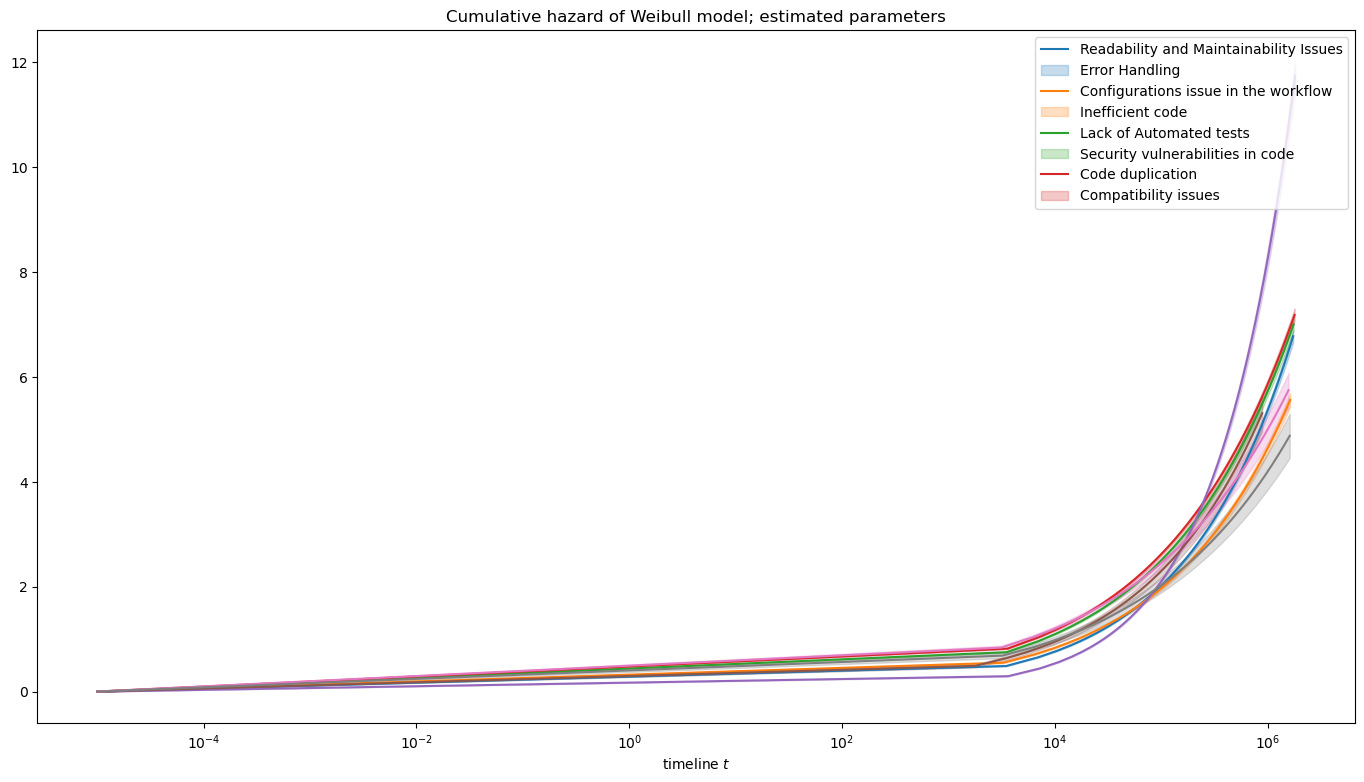

In [1089]:
plot_weibull(df['Rule'].unique() ,df)

# Cox Proportional Hazard Model

Cox-PH model is a semi-parametric model which solves the problem of incorporating covariates. In Cox’s proportional hazard model, the log-hazard is a linear function of the covariates and a population-level baseline hazard

In [1022]:
df_code_duplication = df[df['Rule'] == 'Code duplication']
df_code_duplication['mapping_time_taken'] = df_code_duplication['time_taken'].apply(lambda x : False if x == "unresolved error" else True)
df_code_duplication['time_taken_delta'] = df_code_duplication['time_taken'].apply(lambda x : pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "unresolved error" else 0)
df_code_duplication_x = df_code_duplication[['line','column', 'kind', 'end_column', 'repository', 'commit', 'workflow', 'lines_count', 'commit_year','commit_mon_year', 'time_taken_delta', 'mapping_time_taken']]
df_code_duplication_y = df_code_duplication[['mapping_time_taken', 'time_taken_delta']].to_numpy()
df_code_duplication_x.dtypes

line                    int64
column                  int64
kind                   object
end_column              int64
repository             object
commit                 object
workflow               object
lines_count             int64
commit_year             int64
commit_mon_year        object
time_taken_delta      float64
mapping_time_taken       bool
dtype: object

In [1023]:
# # Identify categorical columns
# categorical_columns = [ 'kind', 'commit_mon_year', 'repository', 'commit','workflow']

# # Convert categorical columns to 'category' dtype
# df_code_duplication_x[categorical_columns] = df_code_duplication_x[categorical_columns].astype('category')


In [963]:
data_x_numeric = OneHotEncoder().fit_transform(df_code_duplication_x)
data_x_numeric

line  column  kind=job-needs  kind=matrix  kind=syntax-check  \
1558       33      13             0.0          1.0                0.0   
1565       31      13             0.0          1.0                0.0   
3356       18       3             0.0          0.0                1.0   
3357       32       3             0.0          0.0                1.0   
3358       27       3             0.0          0.0                1.0   
...       ...     ...             ...          ...                ...   
1128580    49       9             0.0          0.0                1.0   
1128582    51       9             0.0          0.0                1.0   
1128583    50       9             0.0          0.0                1.0   
1128597    28       9             0.0          0.0                1.0   
1128621     9       1             0.0          0.0                1.0   

         end_column  repository=0lnetworkcommunity---libra  \
1558             22                                    0.0   
1565             22                                    0.0   
3356              8                                    0.0   
3357              8                                    0.0   
3358              8                                    0.0   
...             ...                                    ...   
1128580          12                                    0.0   
1128582          12                                    0.0   
1128583          12                                    0.0   
1128597          13                                    0.0   
1128621           5                                    0.0   

         repository=0xpolygon---polygon-edge  repository=0xproject---0x-api  \
1558                                     0.0                            0.0   
1565                                     0.0                            0.0   
3356                                     0.0                            0.0   
3357                                     0.0                            0.0   
3358                                     0.0                            0.0   
...                                      ...                            ...   
1128580                                  0.0                            0.0   
1128582                                  0.0                            0.0   
1128583                                  0.0                            0.0   
1128597                                  0.0                            0.0   
1128621                                  0.0                            0.0   

         repository=281677160---build-actions  ...  commit_mon_year=2023-03  \
1558                                      0.0  ...                      0.0   
1565                                      0.0  ...                      0.0   
3356                                      0.0  ...                      0.0   
3357                                      0.0  ...                      0.0   
3358                                      0.0  ...                      0.0   
...                                       ...  ...                      ...   
1128580                                   0.0  ...                      0.0   
1128582                                   0.0  ...                      0.0   
1128583                                   0.0  ...                      0.0   
1128597                                   0.0  ...                      0.0   
1128621                                   0.0  ...                      0.0   

         commit_mon_year=2023-04  commit_mon_year=2023-05  \
1558                         0.0                      0.0   
1565                         0.0                      0.0   
3356                         0.0                      0.0   
3357                         0.0                      0.0   
3358                         0.0                      0.0   
...                          ...                      ...   
1128580                      0.0                      0.0   
1

In [964]:
# aux = [(e1,e2) for e1,e2 in df_code_duplication_y]

# #Structured array
# new_df_code_duplication_y = np.array(aux, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [993]:
cph = CoxPHFitter(penalizer=0.0001)

cph.fit(data_x_numeric, duration_col = 'time_taken_delta', event_col = 'mapping_time_taken')
cph.print_summary()

/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column commit=007671305dfefb5726ffb202a466069ab0879904 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['mapping_time_taken'].astype(bool)
>>> print(df.loc[events, 'commit=007671305dfefb5726ffb202a466069ab0879904'].var())
>>> print(df.loc[~events, 'commit=007671305dfefb5726ffb202a466069ab0879904'].var())

A very low variance means that the column commit=007671305dfefb5726ffb202a466069ab0879904 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/ehsansiddique/anaconda3/lib/python3.11/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarn

<lifelines.CoxPHFitter: fitted with 7109 total observations, 4599 right-censored observations>
             duration col = 'time_taken_delta'
                event col = 'mapping_time_taken'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 7109
number of events observed = 2510
   partial log-likelihood = -19513.04
         time fit was run = 2024-02-15 13:21:05 UTC

---
                                                                                                                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                                                                                             
line                                                                                                                           -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
column                                                                                                                          0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
kind=job-needs                                                                                                                 -0.02       0.98       4.76            -9.35             9.31                 0.00             10993.73
kind=matrix                                                                                                                     0.06       1.06       2.32            -4.49             4.60                 0.01                99.42
kind=syntax-check                                                                                                              -0.06       0.95       2.44            -4.85             4.73                 0.01               113.65
end_column                                                                                                                     -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
repository=0lnetworkcommunity---libra                                                                                          -0.14       0.87      71.48          -140.24           139.96                 0.00             6.10e+60
repository=0xpolygon---polygon-edge                                                                                             0.00       1.00     100.00          -195.99           196.00                 0.00             1.33e+85
repository=0xproject---0x-api                                                                                                  -0.07       0.94      50.01           -98.08            97.95                 0.00             3.47e+42
repository=281677160---build-actions                                                                                           -0.04       0.97      45.67           -89.55            89.48                 0.00             7.26e+38
repository=42wim---matterbridge                                                                                                -0.06       0.95     100.00          -196.05           195.94                 0.00             1.25e+85
repository=GatoGraphQL---PoP                                                                                                    0.09       1.10      57.82          -113.23           113.42                 0.00             1.81e+49
repository=a-b-street---abstreet                                                                                                0.01       1.01      57.74          -113.16           113.19                 0.00             1.43e+49
repository=a2o---snoopy                                                         

<Axes: >

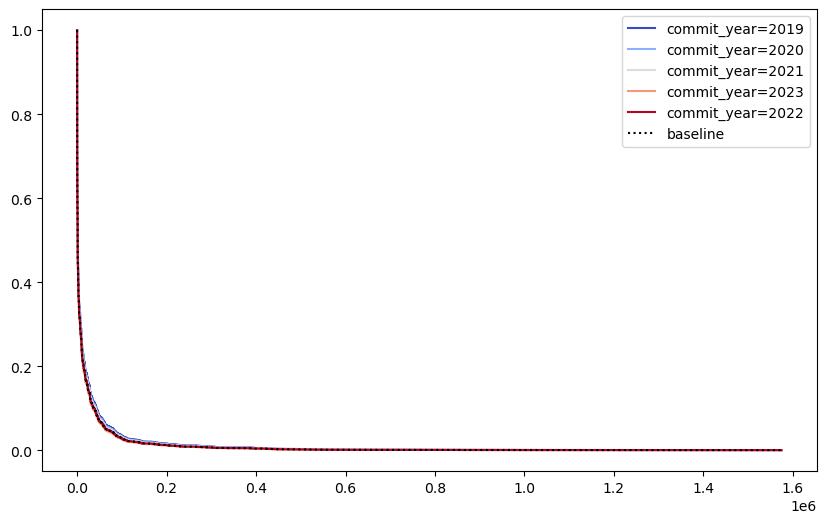

In [1002]:
cph.plot_partial_effects_on_outcome(covariates='commit_year', values=[2019, 2020, 2021, 2023, 2022], cmap='coolwarm')

In [ ]:
# set_config(display="text")  # displays text representation of estimators

# estimator = CoxPHSurvivalAnalysis(alpha=0.01)
# estimator.fit(data_x_numeric, new_df_code_duplication_y)

In [716]:
df.columns

Index(['Unnamed: 0', 'message', 'filepath', 'line', 'column', 'kind',
       'snippet', 'end_column', 'workflow_content', 'repository', 'commit',
       'author_name', 'author_email', 'commiter_name', 'commiter_email',
       'date', 'workflow', 'change_type', 'lines_count', 'commit_year',
       'commit_mon_year', 'next_commit', 'status', 'time_taken', 'Rule'],
      dtype='object')

In [721]:
df['Rule'].value_counts()

Error Handling                            376888
Inefficient code                          271684
Configurations issue in the workflow      234224
Readability and Maintainability Issues    171645
Lack of Automated tests                    45316
Security vulnerabilities in code           12920
Compatibility issues                        9073
Code duplication                            7109
Name: Rule, dtype: int64

In [827]:
df['kind'].value_counts()

deprecated-commands    368212
expression             292188
syntax-check           217987
runner-label           134139
yaml-syntax             37298
matrix                  23520
events                  18617
action                  15106
pyflakes                 8648
glob                     7117
job-needs                3252
id                       1347
shell-name                632
env-var                   401
permissions               235
workflow-call             160
Name: kind, dtype: int64

In [842]:
df[df['kind'] == 'yaml-syntax']['message'].unique()[1000:1300]

array(['could not parse as YAML: yaml: line 59: found character that cannot start any token',
       'could not parse as YAML: yaml: line 82: found unexpected end of stream',
       'could not parse as YAML: yaml: line 99: found unexpected end of stream',
       'could not parse as YAML: yaml: line 306: found unexpected end of stream',
       'could not parse as YAML: yaml: line 64: found character that cannot start any token',
       'could not parse as YAML: yaml: line 227: mapping values are not allowed in this context',
       'could not parse as YAML: yaml: line 133: mapping values are not allowed in this context',
       'could not parse as YAML: yaml: line 152: found character that cannot start any token',
       'could not parse as YAML: yaml: line 56: found character that cannot start any token',
       'could not parse as YAML: yaml: line 93: found unexpected end of stream',
       'could not parse as YAML: yaml: line 299: mapping values are not allowed in this context',
    

### Checking the workflow file name


In [1463]:
check = df[df['message'].str.contains(r'type of "(.*?)" input is \"number\" but its default value "(.*?)" cannot be parsed as a float number: (.*?)', regex=True)]

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_30579/3026303712.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  check = df[df['message'].str.contains(r'type of "(.*?)" input is \"number\" but its default value "(.*?)" cannot be parsed as a float number: (.*?)', regex=True)]


In [1464]:
check[['message', 'workflow', 'workflow_content', 'kind','line', 'column', 'commit','filepath']]

Empty DataFrame
Columns: [message, workflow, workflow_content, kind, line, column, commit, filepath]
Index: []

In [872]:
df['filepath'].nunique()

370381